In [1]:
import subprocess
subprocess.call(["pip", "install", "projectq", "matplotlib"])

0

In [2]:
from projectq import MainEngine

# H = Hadamard gate, H|0> -> (|0> + |1>)/sqrt(2)
#                    H|1> -> (|0> - |1>)/sqrt(2)
# X = Pauli X (not) gate.  X|0> -> |1>
#                          X|1> -> |0>
# Z = Pauli Z gate  Z|0> -> |0>
#                   Z|1> -> -|1>
# Measure - perform measurment on a given qubit
# All - performs operation on all qubits in given register
from projectq.ops import H, Z, X, Measure, All

# Loop - in quantum computing there is no such thing as classical loop. It just duplicates given operation n times
# Control - acts like an if statement, code inside is executed based on qubit value passed as argument
from projectq.meta import Loop, Compute, Uncompute, Control

In [3]:
def magic_function(qubits, output):
    # flip 0,1,3 qubits, so 0000 -> 1101, but 0010 -> 1111
    with Compute(engine):
        X | qubits[0]
        X | qubits[1]
        X | qubits[3]
    # if all qubits in register are 1
    with Control(engine, qubits):
        # X(|0> - |1>)/sqrt(2) -> (|1> - |0>)/sqrt(2)
        X | output
    Uncompute(engine)

In [4]:
results = []
for _ in range(100):
    engine = MainEngine()
    # create quantum register with 4 qubits, all in state |0>
    register = engine.allocate_qureg(4)
    # allocate one qubit, starts with state |0> 
    function_out = engine.allocate_qubit()
    
    # apply hadamard gate to all qubits in register
    # H|0> -> (|0> + |1>)/sqrt(2)
    All(H) | register
    
    # X|0> -> |1>
    X | function_out
    # H|1> -> (|0> - |1>)/sqrt(2)
    H | function_out
    
    with Loop(engine, 10):
        magic_function(register, function_out)

        with Compute(engine):
            # H(|0> + |1>)/sqrt(2) -> |0>
            All(H) | register
            # X |0> -> |1>
            All(X) | register

        with Control(engine, register[0:-1]):
            Z | register[-1]

        Uncompute(engine)
    
    All(Measure) | register
    Measure | function_out
    engine.flush()
    
    results.append(tuple(int(qubit) for qubit in register))

In [5]:
from collections import Counter
counts = Counter(results)

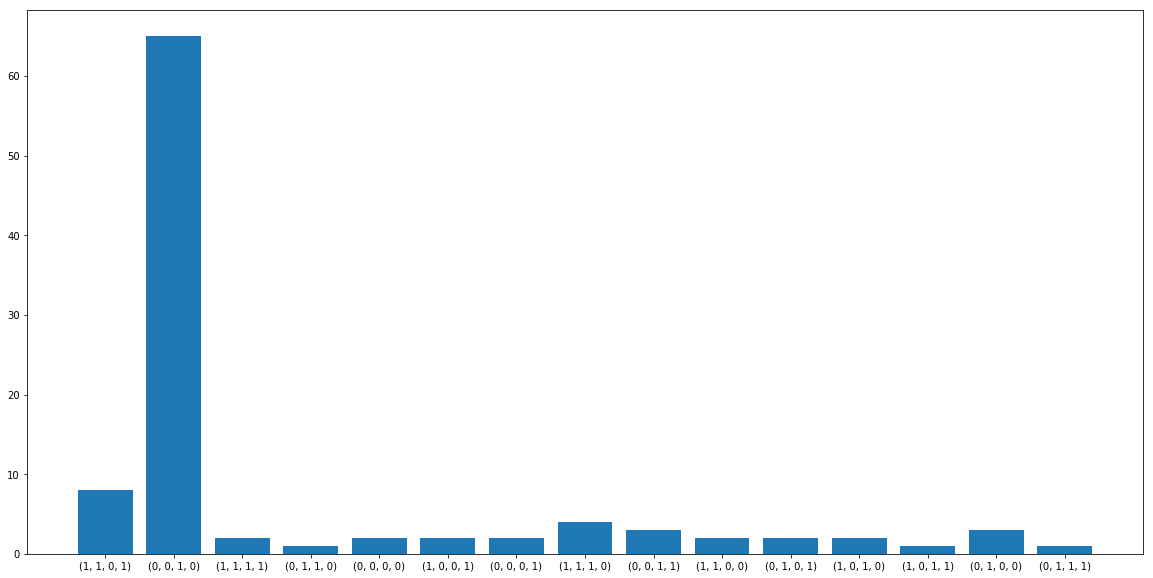

In [11]:
import matplotlib.pyplot as plot
%matplotlib inline
y_pos = list(range(len(counts.keys())))
plot.figure(figsize=(20,10))
plot.bar(y_pos, counts.values())
_ = plot.xticks(y_pos, list(counts.keys()))